# 0.Вспомогательные ссылки

In [ ]:
# !pip install yahoo_fin
# !pip install yoptions
# !pip install pandas_datareader
# pip install lightgbm
# !pip install --upgrade xlrd

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.pyplot import figure
import seaborn as sns
import os
import datetime
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from pandas_datareader import data
from functools import reduce
import yoptions as yo
from yahoo_fin import options
from scipy.stats import norm
from tabulate import tabulate

### Связывание N разных файлов в 1 файл (Предварительно скачанных с сайта Investing.com (библиотека в момент написания работы не работала из-за обновления firewall), либо с сайта CFTC)

In [2]:
# os.chdir("C:/Users/pshein/Desktop/Другое/Учёба/Выгрузки/CFTC FUTURES ONLY")
# extension = 'xls'
# all_filenames = [i for i in glob.glob('*.{}'.format(extension))]

# #combine all files in the list
# combined_csv = pd.concat([pd.read_excel(f) for f in all_filenames])
# #export to csv
# combined_csv.to_csv( "futures_statistics.csv", index=False, encoding='utf-8-sig')

In [3]:
df = pd.read_csv('D:/Учёба/ВКР/ВсеВыгрузки/CFTC_futures_only.csv')
corn = pd.read_csv('D:/Учёба/ВКР/ВсеВыгрузки/corn.csv')

### Предобработка данных

In [4]:
# print(df.shape[0], df.query('Market_and_Exchange_Names == "WHEAT - CHICAGO BOARD OF TRADE"').shape[0])
df.applymap(lambda x: str(x).replace(',', '.'))
df.Open_Interest_All = df.Open_Interest_All.apply(lambda x: str(x).replace(',', ''))
df.Report_Date_as_MM_DD_YYYY = pd.to_datetime(df.Report_Date_as_MM_DD_YYYY)
df['difference'] = df.Tot_Rept_Positions_Long_All - df.Tot_Rept_Positions_Short_All
df.Open_Interest_All = df.Open_Interest_All.astype('int')
df = df.sort_values(by = 'Report_Date_as_MM_DD_YYYY', ascending = True)

data = pd.DataFrame(list(df.query('Market_and_Exchange_Names =="CORN - CHICAGO BOARD OF TRADE"')['difference']), 
                    index = df.query('Market_and_Exchange_Names =="CORN - CHICAGO BOARD OF TRADE"')['Report_Date_as_MM_DD_YYYY']) \
                    .rename(columns = {0: 'difference'})
data.index.rename('date', inplace = True)

corn.date = pd.to_datetime(corn.date)
corn.rename(columns = {' value': 'value'}, inplace = True)
corn = corn.query('date > "2010-01-01"')
corn.set_index(corn.date.values, inplace = True)
corn.drop(columns = 'date', inplace = True)

df.Market_and_Exchange_Names = df.Market_and_Exchange_Names.apply(lambda x: str(x).split('-')[0])

# 1. Промежуточная визуализация (На примере фьючерса на кукурузу)

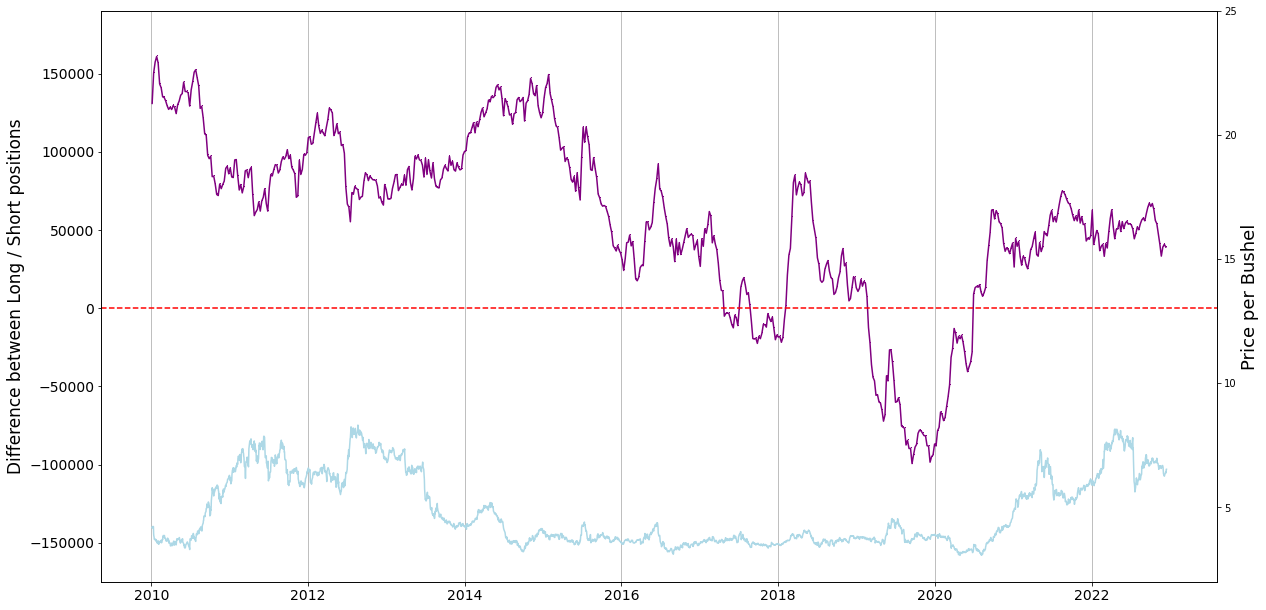

In [5]:
fig,ax = plt.subplots()
ax.plot(data, color = 'purple', marker =',')
ax.set_ylabel("Difference between Long / Short positions", 
              fontsize = 17)
plt.axhline(y = 0, color = 'r', linestyle = '--')
ax.set_ylim(-175000, 190000)


for tick in ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(14)

for tick in ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(14)

ax2=ax.twinx()
ax2.plot(corn, color = 'lightblue')
ax2.set_ylabel("Price per Bushel", 
              fontsize = 18)

for tick in ax.yaxis.get_minor_ticks():
                tick.label.set_fontsize(12)
ax2.set_ylim(2, 25)

ax.grid(axis = 'x')

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(20, 10)

plt.show()

In [6]:
top_actives = df.query('Report_Date_as_MM_DD_YYYY > "2013-01-01"') \
                                    .groupby('Market_and_Exchange_Names', as_index = False) \
                                    .agg({'Open_Interest_All': 'sum'}) \
                                    .sort_values(by = 'Open_Interest_All', ascending = True) \
                                    .rename(columns = {'Open_Interest_All': 'Суммарные_открытые_позиции_млн',
                                                       'Market_and_Exchange_Names': 'Market+Derivative_name'}).tail(10)

top_actives.set_index(top_actives['Market+Derivative_name'].values, inplace = True)
top_actives.drop(columns = 'Market+Derivative_name', inplace = True)
top_actives['Суммарные_открытые_позиции_млн'] = top_actives['Суммарные_открытые_позиции_млн'].astype('int')
top_actives['Суммарные_открытые_позиции_млн'] = top_actives['Суммарные_открытые_позиции_млн'] / 1000000
top_actives.Суммарные_открытые_позиции_млн = round(top_actives.Суммарные_открытые_позиции_млн,2)

### Топ активов за последние 10 лет по показателю суммарного Open Interest

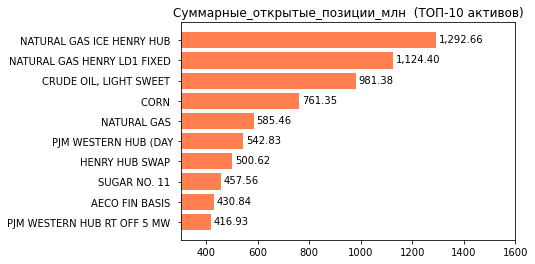

In [10]:
my_plot = plt.barh(top_actives.index, top_actives.Суммарные_открытые_позиции_млн, color = 'coral')
# fig, ax = plt.subplots()

def sep(variable):
    return '{:,.2f}'.format(variable)

for i, v in enumerate(top_actives.Суммарные_открытые_позиции_млн):
    plt.text(v + 10, i- 0.1, str(sep(v)), color='black')


plt.title('Суммарные_открытые_позиции_млн  (ТОП-10 активов)')
plt.xlim(300, 1600)

plt.show()

In [11]:
print('Доля ТОП-10 активов в разрезе OPEN INTEREST составляет', 
      str(
          round(
              df.groupby('Market_and_Exchange_Names') \
                  .agg({'Open_Interest_All': 'sum'}) \
                  .sort_values(by = 'Open_Interest_All', ascending = False).head(10) \
                  .Open_Interest_All.sum() / df.groupby('Market_and_Exchange_Names') \
                  .agg({'Open_Interest_All': 'sum'}) \
                  .Open_Interest_All.sum(), 4
               )*100
      )
            , '%')
print('При том, что эти 10 активов составляют всего ',
      str(round(10 / df.Market_and_Exchange_Names.nunique(), 4)*100),
      '%')

Доля ТОП-10 активов в разрезе OPEN INTEREST составляет 36.809999999999995 %
При том, что эти 10 активов составляют всего  1.53 %
